In [1]:
import os

cwd = os.getcwd()

if cwd.endswith('working'):
    PATH = os.path.join('/kaggle/input/', 'hanacaraka-roboflow')
    os.chdir(PATH)
    new_cwd = os.getcwd()

    print(f"The current working directory was: {cwd}")
    print(f"It has been changed to: {new_cwd}")

else:
    print(f"The current working directory is: {cwd}")

The current working directory was: /kaggle/working
It has been changed to: /kaggle/input/hanacaraka-roboflow


Load Training Data

In [2]:
import pandas as pd

train_df = pd.read_csv('train_classes.csv')
train_df.head()

,filename,ba,ca,da,dha,ga,ha,ja,ka,la,...,na,nga,nya,pa,ra,sa,ta,tha,wa,ya
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
classes = train_df.columns[1:]

print(f"Classes: {classes}")

Classes: Index([' ba', ' ca', ' da', ' dha', ' ga', ' ha', ' ja', ' ka', ' la', ' ma',
       ' na', ' nga', ' nya', ' pa', ' ra', ' sa', ' ta', ' tha', ' wa',
       ' ya'],
      dtype='object')


In [4]:
train_df['label'] = train_df[classes].idxmax(axis=1)
train_df.drop(columns=classes, inplace=True)

train_df.head()

,filename,label
0,na_original_na4-nando-png_047b8e4a-23d2-4984-9...,na
1,ja131-pred3_png.rf.641be3c0db040a9ef0d9ca3e764...,ja
2,ka_original_ka24-mine3-rm5-png_323626c9-08f4-4...,ka
3,wa169-pred-r10_png.rf.65c4b25eba5d8f672b9639ac...,wa
4,sa148-mine-rm5_png.rf.65b2c2b62e59d2eb71afea1b...,sa


Load Validation Data

In [5]:
val_df = pd.read_csv('valid_classes.csv')
classes = val_df.columns[1:]
val_df['label'] = val_df[classes].idxmax(axis=1)
val_df.drop(columns=classes, inplace=True)

val_df.head()

,filename,label
0,ba_original_ba58-mine-r5-png_da355617-4601-42c...,ba
1,tha_original_tha59-mine-png_14942c0b-cf89-4c60...,tha
2,ca63-mine-b_png.rf.6651f23d5e3923e3f5869f5150a...,ca
3,wa_original_wa8-meki-b-png_71916382-2490-4423-...,wa
4,la_original_la9-meki-png_2fda8a06-5a2e-4631-b9...,la


Load Testing Data

In [6]:
test_df = pd.read_csv('test_classes.csv')
classes = test_df.columns[1:]
test_df['label'] = test_df[classes].idxmax(axis=1)
test_df.drop(columns=classes, inplace=True)

test_df.head()

,filename,label
0,ya_original_ya92-mine3-b-png_bbe9944d-6ddd-4bf...,ya
1,da86-mine_png.rf.11496a515f7f6cc4bec9df9340c77...,da
2,dha_original_dha90-mine3-b-png_10e4954e-1ddc-4...,dha
3,ka_original_ka83-mine3-b-png_a996444a-a42f-4b0...,ka
4,tha_original_tha97-mine3-png_446e0772-7dda-432...,tha


# Build the Data Generators (Data Augmentation)

In [7]:
label_encoded = {}

for i, label in enumerate(train_df['label'].unique()):
    label_encoded[label] = i
    
label_encoded

{' na': 0,
 ' ja': 1,
 ' ka': 2,
 ' wa': 3,
 ' sa': 4,
 ' nya': 5,
 ' dha': 6,
 ' pa': 7,
 ' nga': 8,
 ' tha': 9,
 ' ra': 10,
 ' ya': 11,
 ' da': 12,
 ' ca': 13,
 ' ha': 14,
 ' ga': 15,
 ' ta': 16,
 ' ma': 17,
 ' ba': 18,
 ' la': 19}

In [8]:
X_train = train_df['filename']
y_train = train_df['label']

X_val = val_df['filename']
y_val = val_df['label']

X_test = test_df['filename']
y_test = test_df['label']

print(f"{X_train.shape[0]} {X_val.shape[0]} {X_test.shape[0]}")

2700 800 400


In [9]:
from torch.utils.data import Dataset
from PIL import Image

class HanacarakaDataset (Dataset):
    def __init__(self, x, y, maps_label=label_encoded, transform=None):
        self.X = x
        self.y = y
        self.dicts = maps_label
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = Image.open('images/' + self.X.iloc[idx]).convert('RGB')
        label = self.dicts[self.y.iloc[idx]]
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [10]:
import torchvision.transforms as transforms
import numpy as np
import cv2

from torch.utils.data import DataLoader

def cvt_grayscale(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    return Image.fromarray(img)

def cvt_rgb(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def erode_img(img, kernel_size=(3,3)):
    kernel = np.ones(kernel_size, np.uint8)
    img = cv2.erode(np.array(img), kernel, iterations=1)
    return Image.fromarray(img)

def adaptive_threshold(img):
    img = cv2.adaptiveThreshold(np.array(img), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(img)

train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(adaptive_threshold),
    transforms.RandomRotation(10, fill=255),
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.Lambda(cvt_grayscale),
    transforms.Lambda(adaptive_threshold),
    transforms.Lambda(cvt_rgb),
    transforms.ToTensor(),
])

train_dataset = HanacarakaDataset(X_train, y_train, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = HanacarakaDataset(X_val, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = HanacarakaDataset(X_test, y_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
feature, label = next(iter(train_loader))
feature.shape, len(train_loader)

(torch.Size([32, 3, 100, 100]), 85)

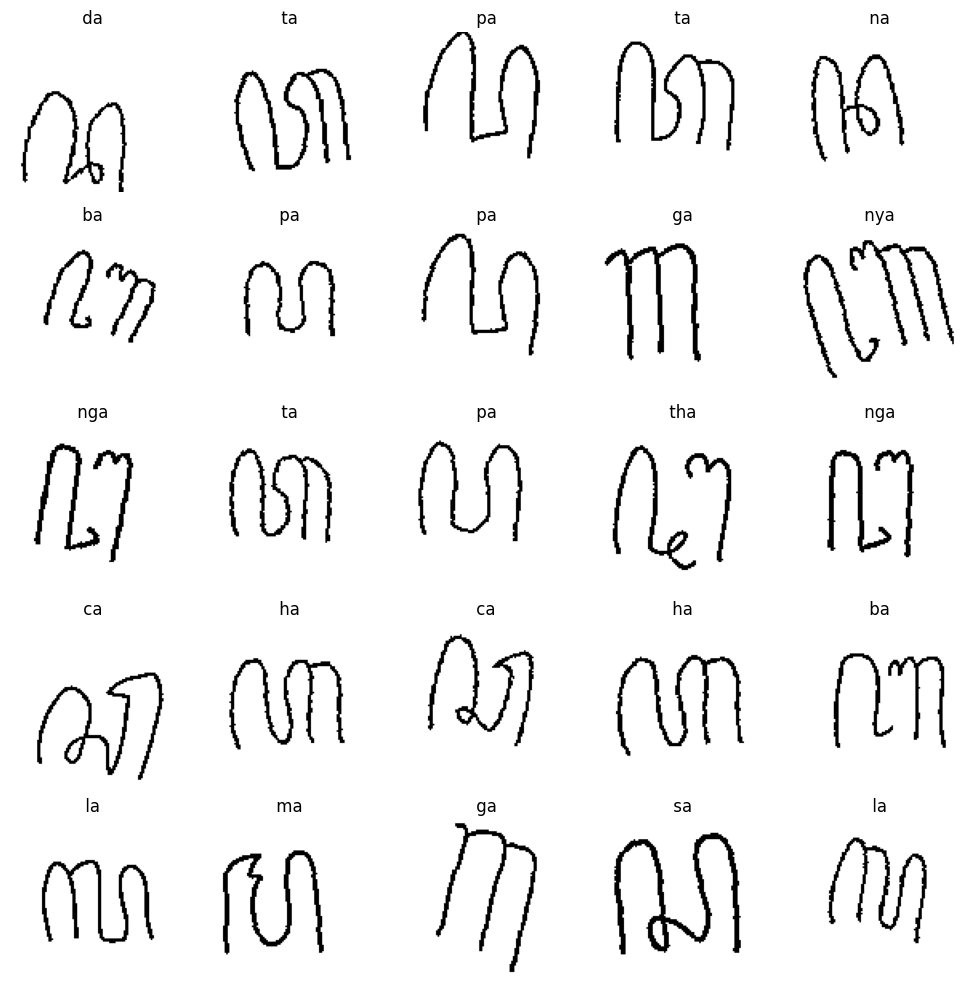

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for img, label, ax in zip(feature, label, axs.flatten()):
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [13]:
import torch.nn as nn
from torchvision.models import MobileNet_V2_Weights
from torchvision.models import mobilenet_v2


class HanacarakaMobileNetV2(nn.Module):
    """
    MobileNetV3 were used as the baseline model. It's a CNN based architecture that were designed for mobile and edge devices.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.freeze()

        self.model.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [14]:
def train(
        model, train_loader, val_loader, criterion, optimizer, early_stop_epochs=5, max_epochs=20,
        history = None
):
    best_val_accuracy = 0.0
    best_epoch = 0
    epoch = 0

    while epoch < max_epochs:
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        correct_preds_train = 0
        total_preds_train = 0
        correct_preds = 0
        total_preds = 0

        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted_train = torch.max(output.data, 1)
            total_preds_train += label.size(0)
            correct_preds_train += (predicted_train == label).sum().item()

        train_accuracy = correct_preds_train / total_preds_train

        model.eval()
        with torch.no_grad():
            for feature, label in val_loader:
                feature, label = feature.to(device), label.to(device)

                output = model(feature)
                loss = criterion(output, label)

                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_preds += label.size(0)
                correct_preds += (predicted == label).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        
        if history is not None:
            history.append((train_loss/len(train_loader), avg_val_loss, train_accuracy, val_accuracy))
        
        print(
            f'Epoch {epoch+1} | '
            f'Train Loss: {train_loss/len(train_loader):.4f} | '
            f'Train Accuracy: {train_accuracy:.4f} | '
            f'Val Loss: {avg_val_loss:.4f} | '
            f'Val Accuracy: {val_accuracy:.4f} | '
        )

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
        elif (epoch - best_epoch) >= early_stop_epochs:
            print('Early Stopping...')
            break

        epoch += 1

    return model

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HanacarakaMobileNetV2(num_classes=len(label_encoded)).to(device)
hist_train = []

criterion = nn.NLLLoss()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.4MB/s]


In [16]:
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=1758be9928e16fc06f53a7e6d664e8e43ad3a7fa3d13a8f0a588798a5cd17667
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


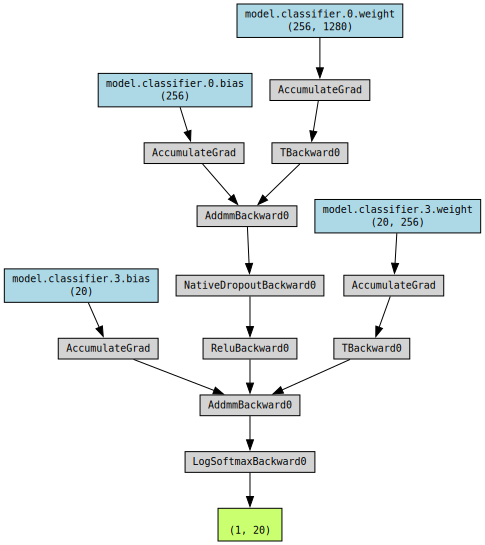

In [17]:
import torch
from torchviz import make_dot

model = model.to(device)

dummy_input = torch.zeros(1, 3, 100, 100).to(device)

out = model(dummy_input)

make_dot(out, params=dict(model.named_parameters()))

Learning Rate 1e-3

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

model = train(model, train_loader, val_loader, criterion, optimizer, early_stop_epochs = 2, max_epochs = 15, history=hist_train)

Epoch 1 | Train Loss: 2.5271 | Train Accuracy: 0.2507 | Val Loss: 2.1785 | Val Accuracy: 0.3525 | 
Epoch 2 | Train Loss: 1.8565 | Train Accuracy: 0.4226 | Val Loss: 1.8552 | Val Accuracy: 0.4288 | 
Epoch 3 | Train Loss: 1.5484 | Train Accuracy: 0.5181 | Val Loss: 1.7775 | Val Accuracy: 0.4437 | 
Epoch 4 | Train Loss: 1.4154 | Train Accuracy: 0.5481 | Val Loss: 1.7464 | Val Accuracy: 0.4575 | 
Epoch 5 | Train Loss: 1.3548 | Train Accuracy: 0.5730 | Val Loss: 1.6612 | Val Accuracy: 0.4600 | 
Epoch 6 | Train Loss: 1.2790 | Train Accuracy: 0.5941 | Val Loss: 1.7597 | Val Accuracy: 0.4512 | 
Epoch 7 | Train Loss: 1.2575 | Train Accuracy: 0.6056 | Val Loss: 1.6196 | Val Accuracy: 0.4838 | 
Epoch 8 | Train Loss: 1.2243 | Train Accuracy: 0.6011 | Val Loss: 1.7143 | Val Accuracy: 0.4612 | 
Epoch 9 | Train Loss: 1.1274 | Train Accuracy: 0.6463 | Val Loss: 1.6977 | Val Accuracy: 0.4750 | 
Early Stopping...


Learning Rate 1e-4

In [19]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

model = train(model, train_loader, val_loader, criterion, optimizer, early_stop_epochs = 6, max_epochs = 40, history=hist_train)

Epoch 1 | Train Loss: 0.8808 | Train Accuracy: 0.7174 | Val Loss: 1.2336 | Val Accuracy: 0.5850 | 
Epoch 2 | Train Loss: 0.5186 | Train Accuracy: 0.8293 | Val Loss: 0.8603 | Val Accuracy: 0.7075 | 
Epoch 3 | Train Loss: 0.3823 | Train Accuracy: 0.8878 | Val Loss: 0.6846 | Val Accuracy: 0.7625 | 
Epoch 4 | Train Loss: 0.2666 | Train Accuracy: 0.9148 | Val Loss: 0.6715 | Val Accuracy: 0.7525 | 
Epoch 5 | Train Loss: 0.1935 | Train Accuracy: 0.9411 | Val Loss: 0.5573 | Val Accuracy: 0.8037 | 
Epoch 6 | Train Loss: 0.1714 | Train Accuracy: 0.9444 | Val Loss: 0.4702 | Val Accuracy: 0.8350 | 
Epoch 7 | Train Loss: 0.1409 | Train Accuracy: 0.9567 | Val Loss: 0.4284 | Val Accuracy: 0.8625 | 
Epoch 8 | Train Loss: 0.1027 | Train Accuracy: 0.9715 | Val Loss: 0.3499 | Val Accuracy: 0.8925 | 
Epoch 9 | Train Loss: 0.0789 | Train Accuracy: 0.9763 | Val Loss: 0.3051 | Val Accuracy: 0.9038 | 
Epoch 10 | Train Loss: 0.0685 | Train Accuracy: 0.9796 | Val Loss: 0.3057 | Val Accuracy: 0.9062 | 
Epoch 11 

In [20]:
train_loss, val_loss, train_acc, val_acc = None, None, None, None

if hist_train:
    train_loss, val_loss, train_acc, val_acc = zip(*hist_train)

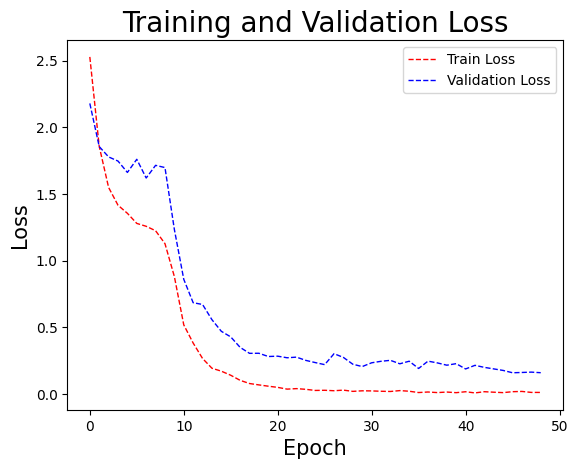

In [21]:
if hist_train:
    plt.plot(train_loss, label='Train Loss', color='red', linestyle='dashed', linewidth=1)
    plt.plot(val_loss, label='Validation Loss', color='blue', linestyle='dashed', linewidth=1)
    plt.title('Training and Validation Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend()
    plt.show()

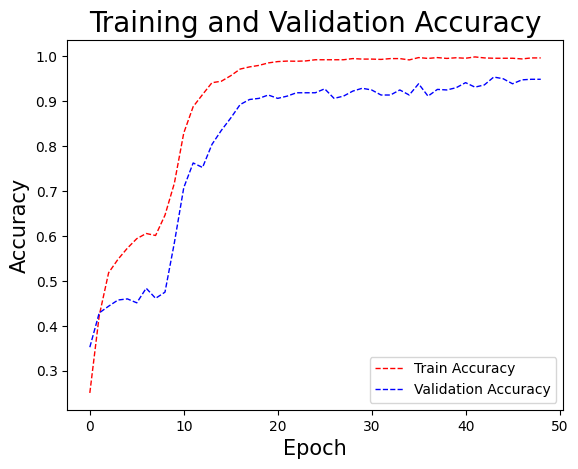

In [22]:
if hist_train:
    plt.plot(train_acc, label='Train Accuracy', color='red', linestyle='dashed', linewidth=1)
    plt.plot(val_acc, label='Validation Accuracy', color='blue', linestyle='dashed', linewidth=1)
    plt.title('Training and Validation Accuracy', fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend()
    plt.show()

In [23]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for feature, label in test_loader:
            feature, label = feature.to(device), label.to(device)

            output = model(feature)
            _, predicted = torch.max(output, 1)

            total += label.size(0)
            correct += (predicted == label).sum().item()

    return correct/total

In [24]:
test(model, test_loader)

0.98

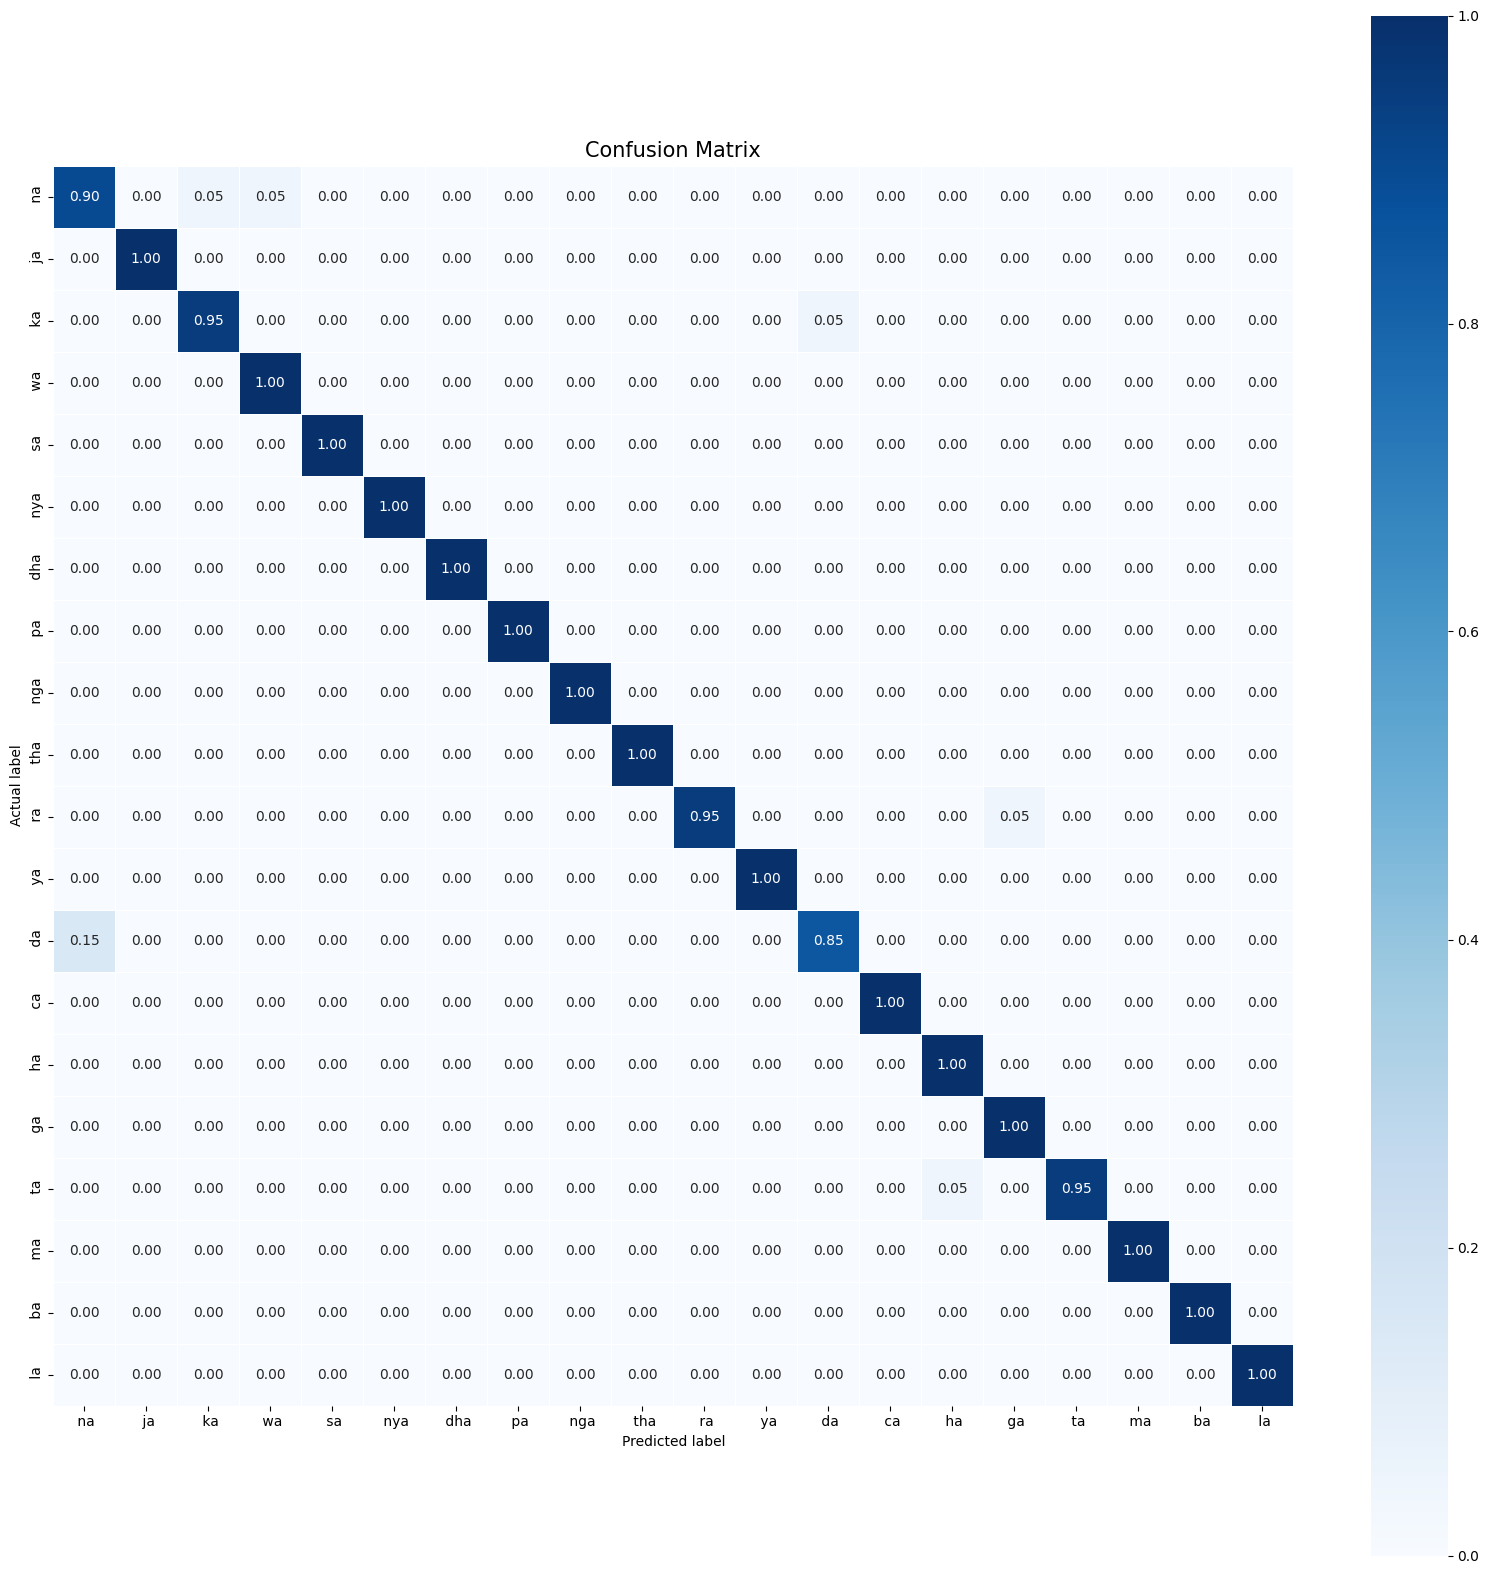

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for feature, label in test_loader:
        feature, label = feature.to(device), label.to(device)

        output = model(feature)
        _, predicted = torch.max(output, 1)

        y_true.extend(label.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true_decoded = [list(label_encoded.keys())[list(label_encoded.values()).index(label)] for label in y_true]
y_pred_decoded = [list(label_encoded.keys())[list(label_encoded.values()).index(pred)] for pred in y_pred]

cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=list(label_encoded.keys()))

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues',
            xticklabels=list(label_encoded.keys()), yticklabels=list(label_encoded.keys()));

plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
plt.show()

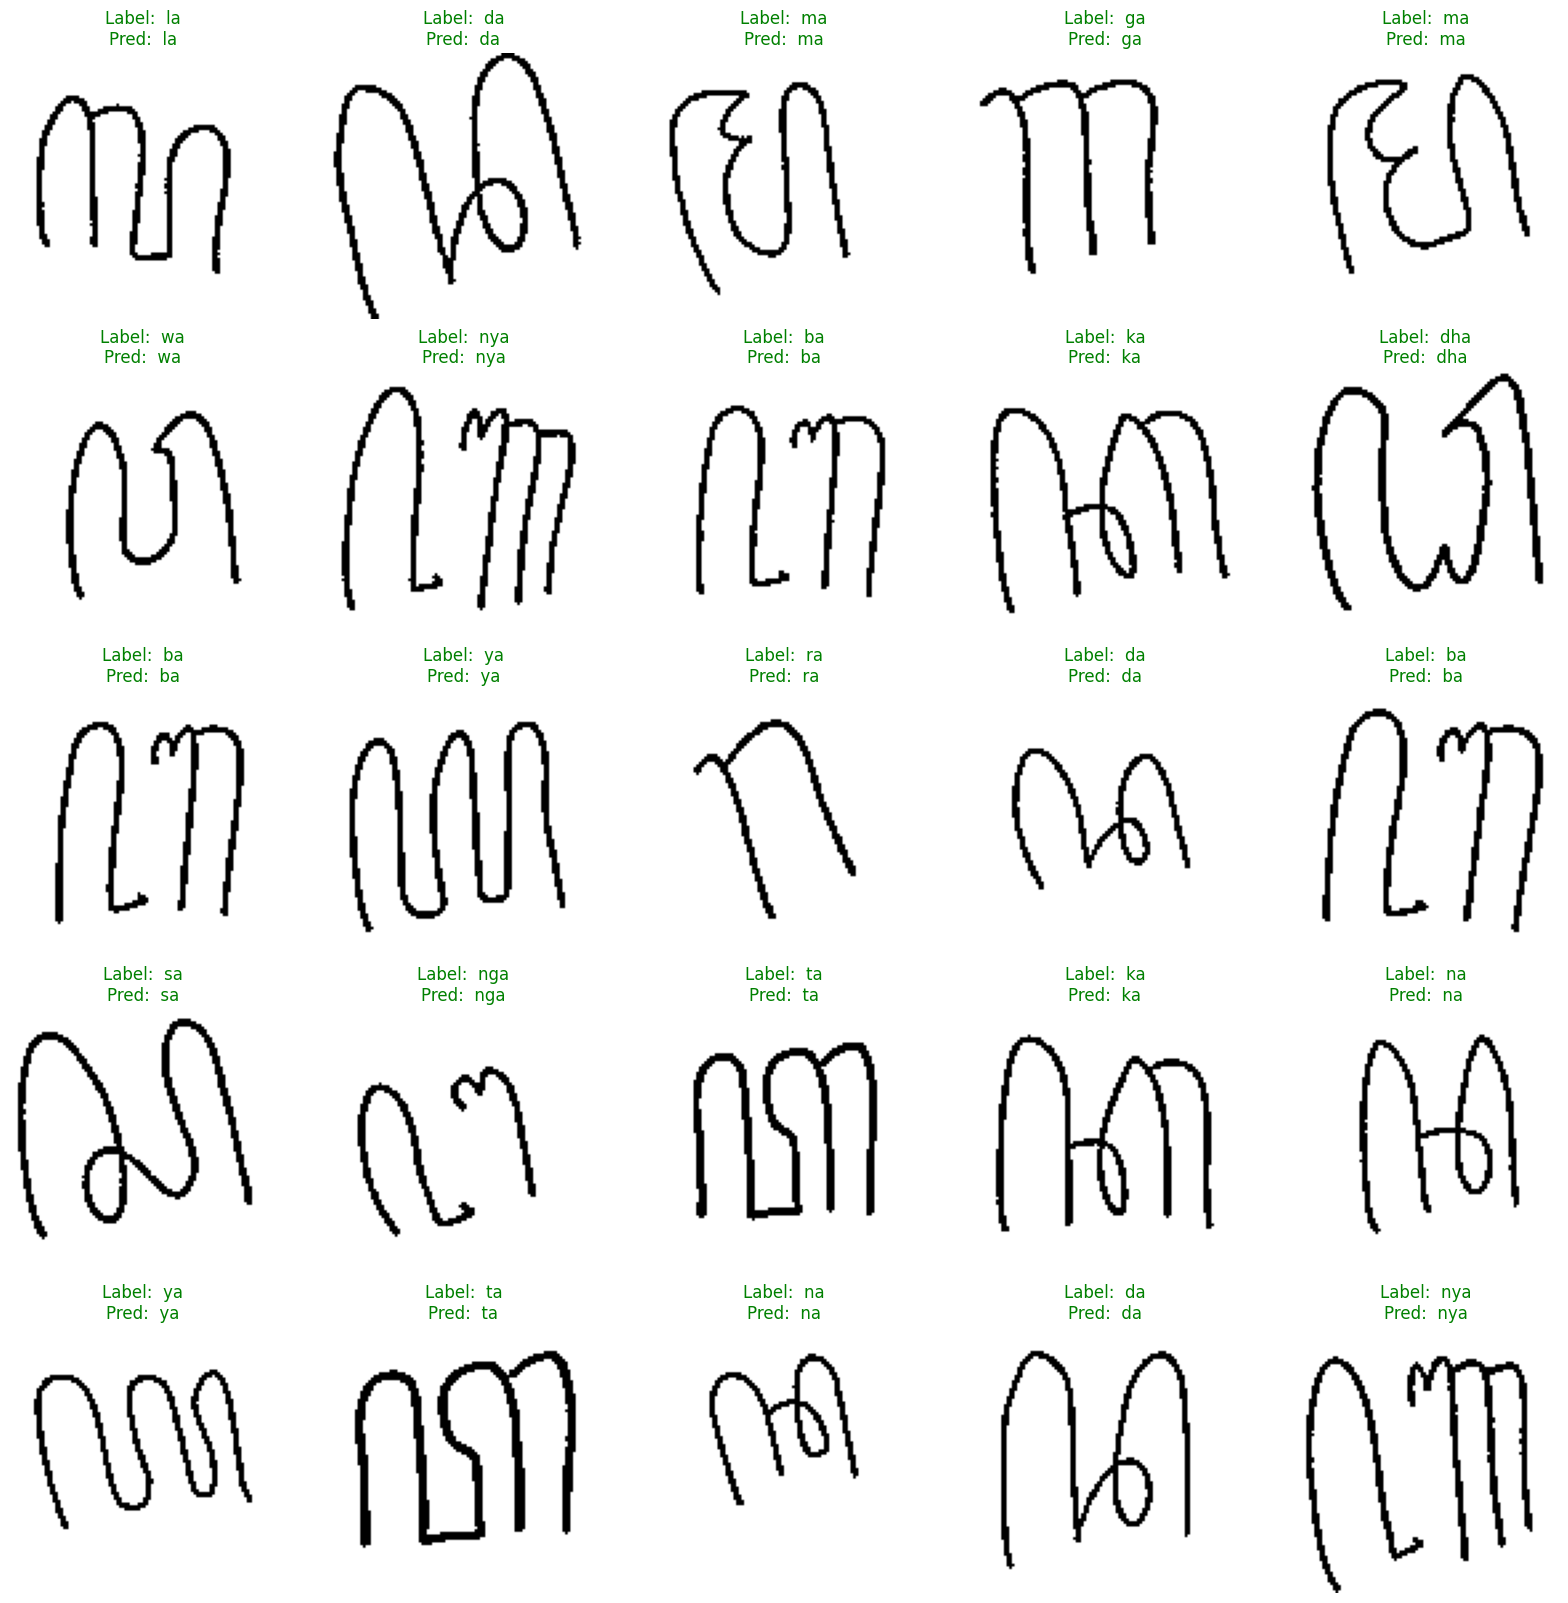

In [26]:
for feature, label in test_loader:
    feature, label = feature.to(device), label.to(device)
    output = model(feature)
    _, predicted = torch.max(output, 1)

    break

fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for img, label, pred, ax in zip(feature, label, predicted, axs.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu().squeeze(), cmap='gray')
    ax.axis('off')
    label = list(label_encoded.keys())[list(label_encoded.values()).index(label)]
    pred = list(label_encoded.keys())[list(label_encoded.values()).index(pred)]
    if label == pred:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f'Label: {label}\nPred: {pred}', color=color)